<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/VGGNetPretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [52]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [53]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [54]:
# Import a function from sklearn to calculate the confusion-matrix.
def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [55]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [56]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict(generator_test, steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [57]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)


In [58]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [59]:
train_dir = 'drive/MyDrive/mri_images/train'
test_dir = 'drive/MyDrive/mri_images/test'
save_dir = 'drive/MyDrive/mri_images/augmented_images'

In [60]:
model = VGG16(include_top=True, weights='imagenet')

In [61]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

In [62]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [63]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [64]:
batch_size = 20

In [65]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

In [66]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 2552 images belonging to 3 classes.


In [67]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 569 images belonging to 3 classes.


In [68]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=input_shape,
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 2042 files for training.


In [69]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=input_shape,
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 2042 files for training.


In [70]:
class_names = train_ds.class_names
print(class_names)
NUM_CLASSES = int(3)

['0', '1', '2']


In [71]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 224, 224, 3)
(20,)


In [72]:
steps_test = generator_test.n / batch_size
steps_test

28.45

In [73]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [74]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [75]:
class_names = list(generator_train.class_indices.keys())
class_names

['0', '1', '2']

In [76]:
num_classes = generator_train.num_classes
num_classes

3

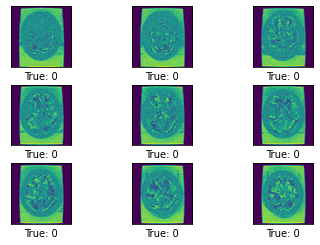

In [77]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [78]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [79]:
class_weight

array([0.70770937, 1.40374037, 1.14336918])

In [80]:
class_names

['0', '1', '2']

In [114]:
def predict(image_path):
    for image, label in image_path:
        for i in range(4):
            #aug_img = img_augmentation(image)
            ax = plt.subplot(3, 3, i + 1)
        
            plt.imshow(image[0].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    
    # Convert the PIL image to a numpy-array with the proper shape.
    
    img_array = np.expand_dims(np.array(image), axis=0)
    
    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
          print("{0:>6.2%} : {1}".format(score, name))
   

In [115]:
predict(train_ds.take(0))

UnboundLocalError: ignored

In [83]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [84]:
transfer_layer = model.get_layer('block5_pool')

In [85]:
transfer_layer.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [86]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [87]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [88]:
optimizer = Adam(lr=1e-5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [89]:
loss = 'categorical_crossentropy'

In [90]:
metrics = ['categorical_accuracy']

In [91]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [92]:
print_layer_trainable()

True:	input_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [93]:
conv_model.trainable = False

In [94]:
for layer in conv_model.layers:
    layer.trainable = False

In [95]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [96]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [97]:
epochs = 10
steps_per_epoch = 10

In [98]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=generator_test)

Epoch 1/10
10/10 [==============================] - 223s 24s/step - loss: 1.1829 - categorical_accuracy: 0.4450 - val_loss: 1.0042 - val_categorical_accuracy: 0.3919
Epoch 2/10
10/10 [==============================] - 48s 5s/step - loss: 1.0032 - categorical_accuracy: 0.5250 - val_loss: 0.9898 - val_categorical_accuracy: 0.4692
Epoch 3/10
10/10 [==============================] - 47s 5s/step - loss: 1.0093 - categorical_accuracy: 0.5400 - val_loss: 1.0041 - val_categorical_accuracy: 0.4446
Epoch 4/10
10/10 [==============================] - 47s 5s/step - loss: 0.9014 - categorical_accuracy: 0.5900 - val_loss: 1.0611 - val_categorical_accuracy: 0.4095
Epoch 5/10
10/10 [==============================] - 41s 4s/step - loss: 0.7933 - categorical_accuracy: 0.6300 - val_loss: 1.1561 - val_categorical_accuracy: 0.5272
Epoch 6/10
10/10 [==============================] - 43s 4s/step - loss: 0.7521 - categorical_accuracy: 0.6900 - val_loss: 1.0658 - val_categorical_accuracy: 0.4376
Epoch 7/10
10/

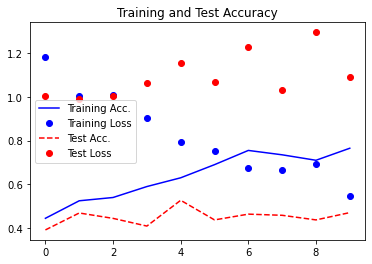

In [99]:
plot_training_history(history)

In [100]:
result = new_model.evaluate(generator_test, steps=steps_test)

28/28 [==============================] - 4s 139ms/step - loss: 1.0887 - categorical_accuracy: 0.4710


In [101]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 47.10%


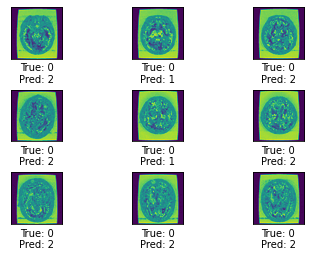

Confusion matrix:
[[ 79  19 138]
 [ 96  27  18]
 [ 27   3 162]]
(0) 0
(1) 1
(2) 2


In [102]:
example_errors()

In [103]:
conv_model.trainable = True

In [104]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [105]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [106]:
optimizer_fine = Adam(lr=1e-7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [107]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [109]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=generator_test)

Epoch 1/10
10/10 [==============================] - 28s 3s/step - loss: 0.5580 - categorical_accuracy: 0.7800 - val_loss: 1.0916 - val_categorical_accuracy: 0.4675
Epoch 2/10
10/10 [==============================] - 29s 3s/step - loss: 0.6622 - categorical_accuracy: 0.7450 - val_loss: 1.0943 - val_categorical_accuracy: 0.4692
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.6577 - categorical_accuracy: 0.7344 - val_loss: 1.0916 - val_categorical_accuracy: 0.4675
Epoch 4/10
10/10 [==============================] - 24s 3s/step - loss: 0.6343 - categorical_accuracy: 0.7350 - val_loss: 1.0881 - val_categorical_accuracy: 0.4675
Epoch 5/10
10/10 [==============================] - 21s 2s/step - loss: 0.5316 - categorical_accuracy: 0.8050 - val_loss: 1.0870 - val_categorical_accuracy: 0.4675
Epoch 6/10
10/10 [==============================] - 20s 2s/step - loss: 0.6506 - categorical_accuracy: 0.7600 - val_loss: 1.0872 - val_categorical_accuracy: 0.4692
Epoch 7/10
10/10

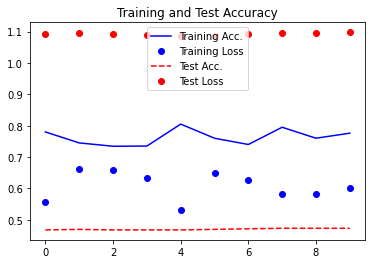

In [110]:
plot_training_history(history)

In [111]:
result = new_model.evaluate(generator_test, steps=steps_test)

28/28 [==============================] - 4s 138ms/step - loss: 1.0980 - categorical_accuracy: 0.4728


In [112]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 47.28%


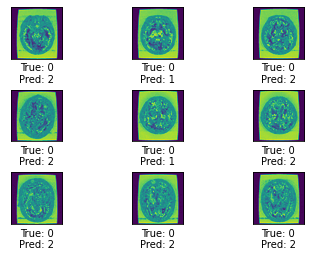

Confusion matrix:
[[ 79  16 141]
 [ 96  27  18]
 [ 26   3 163]]
(0) 0
(1) 1
(2) 2


In [113]:
example_errors()